In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Input
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Input
from tensorflow.keras.models import Sequential
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap


Instructions for updating:
non-resource variables are not supported in the long term


c:\Users\artur\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Tensorflow version:", tf.__version__)

NumPy version: 1.19.5
Pandas version: 1.3.5
Tensorflow version: 2.4.1


# 1 - Data Preprocessing

In [3]:
def processar_dados_ano(caminho_arquivo, escolas_comuns):
    df = pd.read_csv(caminho_arquivo, encoding='latin1',sep=None,engine='python',on_bad_lines='skip')   
    df = df[(df['TP_DEPENDENCIA'] == 3)]
    df = df[df['CO_ENTIDADE'].isin(escolas_comuns)]
    colunas_para_remover = [col for col in df.columns if (col.startswith('DS_') or col.startswith('NU_') or col.startswith('DT_') or col.startswith('CO_') or col.startswith('NO_'))]
    df_limpo = df.drop(columns=colunas_para_remover).drop(columns=['SG_UF'])
    colunas_com_nan = df_limpo.columns[df_limpo.isnull().any()].tolist()
    return df_limpo, colunas_com_nan

# Diretório e inicialização
diretorio = 'dataset/'
primeiro_ano = 2008
caminho_arquivo = f'{diretorio}microdados_ed_basica_{primeiro_ano}_alagoas.csv'
df_primeiro_ano = pd.read_csv(caminho_arquivo, encoding='latin1',sep=None,engine='python',on_bad_lines='skip')
escolas_comuns = set(df_primeiro_ano['CO_ENTIDADE'].unique())

# Identificar escolas comuns em todos os anos
for ano in range(primeiro_ano + 1, 2022):
    caminho_arquivo = f'{diretorio}microdados_ed_basica_{ano}_alagoas.csv'
    df = pd.read_csv(caminho_arquivo, encoding='latin1',sep=None,engine='python',on_bad_lines='skip')
    escolas_comuns = escolas_comuns.intersection(set(df['CO_ENTIDADE'].unique()))
# Lista para armazenar DataFrames de cada ano
dfs = [] 

matriculas_por_ano_fund = []
qt_salas_por_ano = []
qt_funcionarios_por_ano = []
qt_doc_fund_por_ano = []
qt_turma_fund_por_ano = []
anos = range(primeiro_ano, 2022)

# Processar dados de cada ano
for ano in anos:
    caminho_arquivo = f'{diretorio}microdados_ed_basica_{ano}_alagoas.csv'
    df_limpo, colunas_com_nan = processar_dados_ano(caminho_arquivo, escolas_comuns)
    dfs.append(df_limpo)
    
    # Somar o número de matrículas para o ano
    qt_salas_existentes = df_limpo['QT_SALAS_EXISTENTES'].sum()
    qt_funcionarios = df_limpo['QT_FUNCIONARIOS'].sum()
    mat_fund = df_limpo['QT_MAT_FUND'].sum()
    qt_doc_fund = df_limpo['QT_DOC_FUND'].sum()
    qt_turma_fund = df_limpo['QT_TUR_FUND'].sum()

    

    matriculas_por_ano_fund.append(mat_fund)
    qt_salas_por_ano.append(qt_salas_existentes)
    qt_funcionarios_por_ano.append(qt_funcionarios)
    qt_doc_fund_por_ano.append(qt_doc_fund)
    qt_turma_fund_por_ano.append(qt_turma_fund)

    
    print(f"Resumo dos dados de {ano}:")
    print(colunas_com_nan)
    print("--------------------------------------------------------------------\n")
    print(df_limpo.describe())

df_consolidado = pd.concat(dfs, ignore_index=True)

Resumo dos dados de 2008:
[]
--------------------------------------------------------------------

       TP_DEPENDENCIA  TP_CATEGORIA_ESCOLA_PRIVADA  TP_LOCALIZACAO  \
count          2060.0                       2060.0     2060.000000   
mean              3.0                          0.0        1.650485   
std               0.0                          0.0        0.476932   
min               3.0                          0.0        1.000000   
25%               3.0                          0.0        1.000000   
50%               3.0                          0.0        2.000000   
75%               3.0                          0.0        2.000000   
max               3.0                          0.0        2.000000   

       TP_LOCALIZACAO_DIFERENCIADA  TP_SITUACAO_FUNCIONAMENTO  \
count                  2060.000000                     2060.0   
mean                      0.046117                        1.0   
std                       0.324355                        0.0   
min       

In [4]:
correlacao = df_consolidado.corr()

limiar_correlacao = 0.60

correlacoes_fortes_qt_mat_bas = correlacao['QT_MAT_FUND'][np.abs(correlacao['QT_MAT_FUND']) > limiar_correlacao]

variaveis_fortes_lista = correlacoes_fortes_qt_mat_bas.index.drop('QT_MAT_FUND').tolist()

variaveis_fortes_lista.append('QT_MAT_FUND')
print(variaveis_fortes_lista)
corr = df_consolidado[variaveis_fortes_lista].corr()
csv = corr.to_csv('correlacao_fund.csv')

['QT_SALAS_EXISTENTES', 'QT_FUNCIONARIOS', 'IN_FUND_AF', 'QT_MAT_BAS', 'QT_MAT_FUND_AI', 'QT_MAT_FUND_AF', 'QT_MAT_BAS_FEM', 'QT_MAT_BAS_MASC', 'QT_MAT_BAS_ND', 'QT_MAT_BAS_BRANCA', 'QT_MAT_BAS_PARDA', 'QT_MAT_BAS_6_10', 'QT_MAT_BAS_11_14', 'QT_MAT_BAS_15_17', 'QT_MAT_BAS_D', 'QT_MAT_BAS_N', 'QT_DOC_BAS', 'QT_DOC_FUND', 'QT_DOC_FUND_AI', 'QT_DOC_FUND_AF', 'QT_DOC_ESP', 'QT_DOC_ESP_CC', 'QT_TUR_BAS', 'QT_TUR_FUND', 'QT_TUR_FUND_AI', 'QT_TUR_FUND_AF', 'QT_TUR_ESP', 'QT_TUR_ESP_CC', 'QT_MAT_FUND']


In [5]:
dados_ano = {'NU_ANO_CENSO': list(anos), 'QT_MAT_FUND': matriculas_por_ano_fund, 'QT_DOC_FUND': qt_doc_fund_por_ano, 'QT_TUR_FUND': qt_turma_fund_por_ano, 'QT_SALAS_EXISTENTES': qt_salas_por_ano, 'QT_FUNCIONARIOS': qt_funcionarios_por_ano}
df_consolidado = pd.DataFrame(dados_ano)
features = df_consolidado.drop(columns=['QT_MAT_FUND', 'NU_ANO_CENSO']).values
target = df_consolidado['QT_MAT_FUND'].values.reshape(-1, 1)

In [6]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_normalized = scaler_features.fit_transform(features)
target_normalized = scaler_target.fit_transform(target)

In [7]:
def create_sliding_window(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)
window_size = 3  # Usando os 3 anos anteriores

X, y = create_sliding_window(features_normalized, target_normalized, window_size)


In [8]:

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# 2 - Training the Model

In [9]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))  
model.add(LSTM(units=300, return_sequences=True))
model.add(Dropout(0.05))
model.add(LSTM(units=200, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=100, batch_size=1024, verbose=0, validation_data=(X_test, y_test))

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


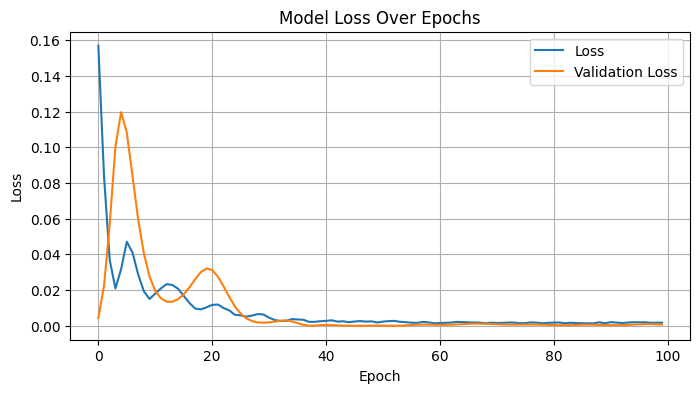

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Recriando os índices para plotagem
train_index = list(range(window_size, split + window_size))
test_index = list(range(split + window_size, len(df_consolidado)))

# Gerando as previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inversão do escalonamento para previsões e valores reais
train_predict_rescaled = scaler_target.inverse_transform(
    np.concatenate([train_predict, np.zeros((train_predict.shape[0], 1))], axis=-1)
)[:, 0]

test_predict_rescaled = scaler_target.inverse_transform(
    np.concatenate([test_predict, np.zeros((test_predict.shape[0], 1))], axis=-1)
)[:, 0]

y_test_rescaled = scaler_target.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))], axis=-1)
)[:, 0]


In [12]:
mae = mean_absolute_error(y_test_rescaled, test_predict_rescaled)
mse = mean_squared_error(y_test_rescaled, test_predict_rescaled)
r2 = r2_score(y_test_rescaled, test_predict_rescaled)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 3925.84
MSE: 15507921.42
R2: -0.35


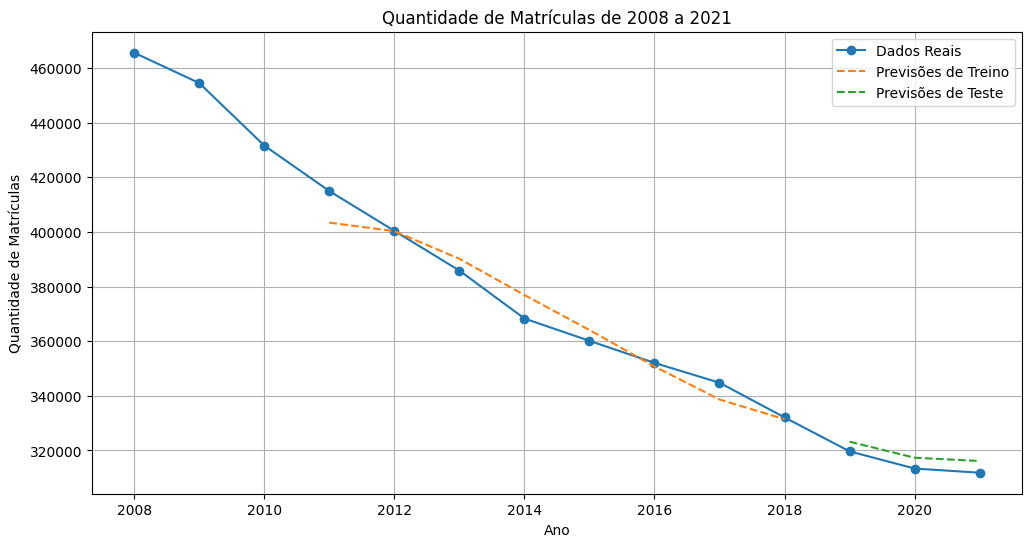

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_consolidado['NU_ANO_CENSO'], df_consolidado['QT_MAT_FUND'], label='Dados Reais', marker='o')
plt.plot(df_consolidado['NU_ANO_CENSO'][train_index], train_predict_rescaled, label='Previsões de Treino', linestyle='--')
plt.plot(df_consolidado['NU_ANO_CENSO'][test_index], test_predict_rescaled, label='Previsões de Teste', linestyle='--')
plt.title('Quantidade de Matrículas de 2008 a 2021')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Matrículas')
plt.legend()
plt.grid(True)
plt.show()

# 3 - SHAP

Formato de X_train: (8, 3, 4)
Formato de X_test: (3, 3, 4)



Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


Dimensões dos shap_values: 1 (3, 3, 4)
Formato do shap_aggregated: (3, 4)


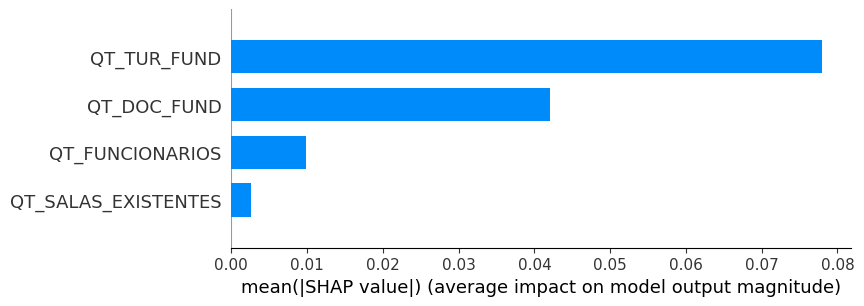

In [14]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# Certifique-se de que X_train e X_test estão no formato correto (n_samples, timesteps, n_features)
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)

# Verificar o formato das entradas
print("Formato de X_train:", X_train_np.shape)
print("Formato de X_test:", X_test_np.shape)

# Criar o explainer usando DeepExplainer - apenas os primeiros 100 samples para otimizar o tempo de computação
explainer = shap.DeepExplainer(model, X_train_np)

# Calcular os valores SHAP - apenas os primeiros 10 samples para uma visualização mais rápida
shap_values = explainer.shap_values(X_test_np)

# Verificar as dimensões dos shap_values
print("Dimensões dos shap_values:", len(shap_values), shap_values[0].shape)

# Reformatar os shap_values para torná-los compatíveis com o shap.summary_plot
# Vamos agregar ao longo da dimensão do tempo (timesteps)
shap_aggregated = np.mean(shap_values[0], axis=1)

# Verifique o novo formato do shap_aggregated
print("Formato do shap_aggregated:", shap_aggregated.shape)

# Assumindo que você tem uma lista de nomes das features que está usando no modelo
feature_names = ['QT_DOC_FUND', 'QT_TUR_FUND','QT_SALAS_EXISTENTES','QT_FUNCIONARIOS']  # Exemplo de nomes de features

# Verifique se o número de features no shap_aggregated e feature_names é o mesmo
if shap_aggregated.shape[1] != len(feature_names):
    raise ValueError("Número de features no shap_aggregated e feature_names não corresponde.")

# Plotar os valores SHAP
shap.summary_plot(shap_aggregated, plot_type='bar', feature_names=feature_names)

# Para evitar problemas com o backend de matplotlib (caso esteja usando um notebook)
plt.show()

In [15]:
# from statsmodels.tsa.stattools import grangercausalitytests

# # Dados de exemplo: Substitua com seus dados reais
# data = {
#     'QT_MAT_BAS': matriculas_por_ano,  # Sua série alvo
#     'QT_DOC_BAS': doc_por_ano,         # Outra variável
#     'QT_TUR_BAS': turmas_por_ano,
#     'QT_MAT_BAS_BRANCA': brancas_por_ano,
#     'QT_MAT_BAS_PARDA': pardas_por_ano,
#     'QT_MAT_BAS_D': diurno_por_ano,
#     'QT_MAT_BAS_N': noturno_por_ano
# }

# # Converter para DataFrame
# df = pd.DataFrame(data)

# # Verificar e imprimir colunas constantes
# for column in df.columns:
#     if df[column].nunique() == 1:
#         print(f"Coluna constante encontrada: {column} - Valor: {df[column].iloc[0]}")

# # Remover colunas constantes
# df = df.loc[:, df.nunique() > 1]

# # Verificar os dados após remoção
# print("Dados após remoção de colunas constantes:")
# print(df.head())

# # Definir o número máximo de lags para testar
# maxlag = 2
# test = 'ssr_chi2test'

# def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
#     """ Cria uma matriz de causalidade de Granger mostrando os valores-p para cada par de variáveis."""
#     df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in df.columns:
#         for r in df.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     df.columns = [var + '_x' for var in variables]
#     df.index = [var + '_y' for var in variables]
#     return df

# # Executar a função com o seu DataFrame
# causation_matrix = grangers_causation_matrix(df, variables=df.columns, verbose=True)

# # Exibir a matriz de causalidade de Granger
# print(causation_matrix)
